# Option 1

_What’s the probability that Samsquanch can traverse a 10x10 forest from top to bottom (the sides are blocked) if 35 trees are uniformly placed in the forest and Samsquanch is modeled as a circle of radius 1?_

Here I opt to simulate the problem in essentially the same way as I solved [part 1](https://github.com/xavierdurawa/XPC/blob/master/8-25-24/8-25-24.ipynb) with just a couple of extra optimizations, namely the use of a ball tree for nearest neighbor search and A* search for finding a path from the left side to the right side (i.e. a blockage for Samsquanch).

In [3]:
import numpy as np
from sklearn.neighbors import BallTree
import networkx as nx

def generate_graph_from_points(points, distance_threshold):
    """
    Generates a graph where an edge exists between two points if they are within
    the specified distance threshold in 2D space.
    
    Parameters:
    - points: np.array of shape (n, 2) where n is the number of points.
    - distance_threshold: float, the distance threshold for connecting points.
    
    Returns:
    - G: networkx.Graph representing the connections between points.
    """
    
    # Create the BallTree from the points
    tree = BallTree(points, leaf_size=2)

    # Query the tree for all pairs of points within the distance threshold
    indices = tree.query_radius(points, r=distance_threshold)
    
    # Create a graph using networkx
    G = nx.Graph()

    # Add edges between points that are within the distance threshold
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if neighbor != i:  # Avoid self-loops
                G.add_edge(i, neighbor)

    return G


In [4]:
def add_head_tail_to_graph(G, points, distance_threshold):
    """
    Adds a 'head' node connected to all points near the left boundary (x < distance_threshold)
    and a 'tail' node connected to all points near the right boundary (x > 10 - distance_threshold).

    Parameters:
    - G: networkx.Graph, the graph generated from points.
    - points: np.array of shape (n, 2), the original points in 2D space.
    - distance_threshold: float, the distance threshold for connecting to the head or tail.
    
    Returns:
    - G: networkx.Graph, updated with 'head' and 'tail' nodes.
    """
    head_node = 'head'
    tail_node = 'tail'

    # Add head and tail nodes to the graph
    G.add_node(head_node)
    G.add_node(tail_node)

    # Find points near the left boundary (x < distance_threshold) and connect to head
    for i, (x, y) in enumerate(points):
        if x < distance_threshold:
            G.add_edge(head_node, i)

    # Find points near the right boundary (x > 10 - distance_threshold) and connect to tail
    for i, (x, y) in enumerate(points):
        if x > 10 - distance_threshold:
            G.add_edge(tail_node, i)

    return G

In [21]:
# Example usage
# np.random.seed(1)  # For reproducibility
square_size = 10
points = np.random.rand(35, 2) * square_size  # 100 random points in 2D space within a 10x10 grid
distance_threshold = 2  # Example threshold

G = generate_graph_from_points(points, distance_threshold)
G = add_head_tail_to_graph(G, points, distance_threshold)

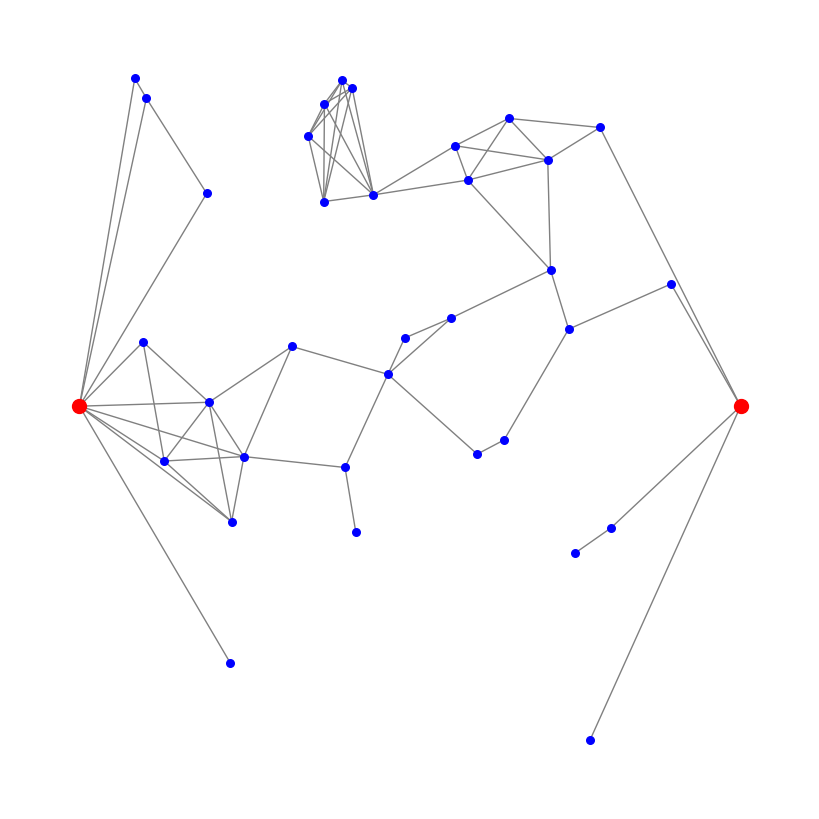

In [22]:
# Visualize the graph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
pos = {i: points[i] for i in range(len(points))}  # Positions of nodes
pos['head'] = (-1, square_size/2)  # Place head to the left of the graph for visualization
pos['tail'] = (square_size+1, square_size/2)  # Place tail to the right of the graph for visualization

nx.draw(G, pos, with_labels=False, node_size=30, node_color='blue', edge_color='gray')
nx.draw_networkx_nodes(G, pos, nodelist=['head', 'tail'], node_color='red', node_size=100)
plt.show()

In [24]:
def heuristic(node, points):
    """
    Heuristic function for A* search.
    The heuristic is the distance from a node to the right side of the graph (i.e., h = 10 - x).
    
    Parameters:
    - node: The node in the graph.
    - points: np.array of shape (n, 2), the original points in 2D space.
    
    Returns:
    - float: The heuristic value (distance from the right side).
    """
    if node == 'head' or node == 'tail':
        return 0  # Head and tail have no heuristic in this context
    x, y = points[node]
    return 10 - x

def astar_search_with_heuristic(graph, points):
    """
    Performs A* search from 'head' to 'tail' using the heuristic h = 10 - x.
    
    Parameters:
    - graph: The graph with 'head' and 'tail' nodes.
    - points: np.array of shape (n, 2), the original points in 2D space.
    
    Returns:
    - list: The shortest path from 'head' to 'tail', or None if no path exists.
    """
    try:
        path = nx.astar_path(graph, 'head', 'tail', heuristic=lambda n, _: heuristic(n, points))
        return path
    except nx.NetworkXNoPath:
        return None

def is_connected(graph):
    """
    Checks if there is a path from 'head' to 'tail' in the graph.
    
    Parameters:
    - graph: networkx.Graph with 'head' and 'tail' nodes.
    
    Returns:
    - bool: True if there is a path from 'head' to 'tail', False otherwise.
    """
    try:
        nx.astar_path(graph, 'head', 'tail', heuristic=lambda n1, n2: 0)  # Heuristic 0 because we don't need it here
        return True
    except nx.NetworkXNoPath:
        return False

# Perform the A* search to find a path from 'head' to 'tail'
path_from_head_to_tail = astar_search_with_heuristic(G, points)

# Display the result
if path_from_head_to_tail:
    print(f"Path found from 'head' to 'tail': {path_from_head_to_tail}")
else:
    print("No path found from 'head' to 'tail'.")

Path found from 'head' to 'tail': ['head', 33, 29, 10, 23, 26, 17, 32, 'tail']


I couldn't really come up with any clever sampling strategy, so I just used a simple random sampling.

In [26]:
def pure_random_sampling_prob(num_samples, num_trees, square_size, distance_threshold):
    """
    Perform pure random sampling to estimate the probability that a randomly generated forest
    with num_trees trees is traversable.
    
    Parameters:
    - num_samples: Number of random configurations to sample.
    - num_trees: Number of trees in the forest.
    - distance_threshold: Distance threshold for connecting points in the graph.
    
    Returns:
    - estimated_prob: Estimated probability of the forest being traversable.
    """
    traversable_count = 0
    
    for _ in range(num_samples):
        # Generate a random configuration of trees
        points = np.random.rand(num_trees, 2) * square_size  # Random points in 10x10 space
        
        # Create the graph for the current configuration
        graph = generate_graph_from_points(points, distance_threshold)
        
        # Add the head and tail nodes and their connections
        graph_with_head_tail = add_head_tail_to_graph(graph, points, distance_threshold)
        
        # Check if there is a path from 'head' to 'tail'
        if is_connected(graph_with_head_tail):
            traversable_count += 1

    # Estimate the probability
    estimated_prob = traversable_count / num_samples
    return estimated_prob

In [42]:
def pure_random_sampling_with_rolling_average(num_samples, num_trees, distance_threshold, square_size=10, window_size=100):
    """
    Perform pure random sampling to estimate the probability that a randomly generated forest
    with num_trees trees is traversable, and plot the rolling average of the estimated probability.
    
    Parameters:
    - num_samples: Number of random configurations to sample.
    - num_trees: Number of trees in the forest.
    - distance_threshold: Distance threshold for connecting points in the graph.
    - window_size: Window size for the rolling average.
    
    Returns:
    - estimated_prob: Final estimated probability of the forest being traversable.
    """
    traversable_count = 0
    rolling_avg = []
    probabilities = []
    
    for i in range(num_samples):
        # Generate a random configuration of trees
        points = np.random.rand(num_trees, 2) * square_size  # Random points in 10x10 space
        
        # Create the graph for the current configuration
        graph = generate_graph_from_points(points, distance_threshold)
        
        # Add the head and tail nodes and their connections
        graph_with_head_tail = add_head_tail_to_graph(graph, points, distance_threshold)
        
        # Check if there is a path from 'head' to 'tail'
        if is_connected(graph_with_head_tail):
            traversable_count += 1
        
        # Update probability and rolling average
        current_prob = traversable_count / (i + 1)
        probabilities.append(current_prob)
        
        if i >= window_size:
            rolling_avg.append(np.mean(probabilities[-window_size:]))
        else:
            rolling_avg.append(np.mean(probabilities[:i+1]))

    # Final estimated probability
    estimated_prob = traversable_count / num_samples
    
    # Plot rolling average
    plt.figure(figsize=(10, 6))
    plt.plot(range(100,num_samples), rolling_avg[100:], label=f"Rolling Average (Window Size={window_size})", color='blue')
    plt.xlabel("Number of Samples")
    plt.ylabel("Estimated Probability")
    plt.title("Rolling Average of Probability Estimation")
    plt.grid(True)
    plt.legend()
    plt.show()

    return estimated_prob

Estimated probability of traversability (1,000,000 simulations): 0.44989


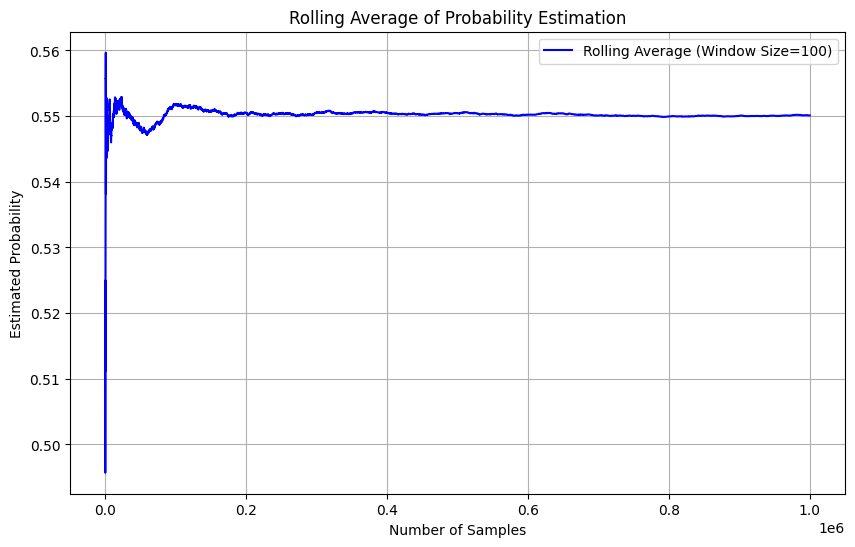

In [11]:
# p = pure_random_sampling_with_rolling_average(num_samples=1000000, num_trees=35, square_size=10, distance_threshold=2)
# print(f"Estimated probability of traversability: {p:.5f}")

# Import image of results of pure random sampling for 1e6 samples
from IPython.display import Image
print("Estimated probability of traversability (1,000,000 simulations): {}".format(1-0.55011))
Image(filename='pure_random_sampling_results_option1.png')

Running this simulation yields a result of $\approx 45\%$ for the probability of Samsquanch being able to make it through.  The variable names I selected are a bit misleading becuase I'm directly calculating the probability that Samsquance can't make it through so its $1 - P$.

# Option 2

_What’s the probability that Samsquanch can traverse a forest from the top to bottom (the sides are blocked) if the forest is modeled as a 10x10 grid with 30 trees uniformly placed on the grid line intersections and Samsquanch is modeled as a circle of radius 1? To clarify, there are 11 horizontal grid lines that the trees could be placed one and 9 vertical grid lines (because the sides are blocked so trees won’t be placed on the leftmost and rightmost grid line). Below is an illustration._

Here again, I will use simulation with the hope that it will provide some grounding as I continue to work towards an analytic method. 

In [5]:
import numpy as np
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

def is_traversable(tree_positions, radius=1.0):
    """
    Determines if Samsquanch can traverse from top to bottom without being blocked by trees.

    Parameters:
    - tree_positions: Nx2 array of tree coordinates.
    - radius: Radius of Samsquanch's obstruction (default 1.0).

    Returns:
    - True if traversable (no barrier exists), False otherwise.
    """
    # Create KDTree for efficient neighbor search
    tree = KDTree(tree_positions)
    
    # Find all pairs of trees within 2*radius distance
    pairs = tree.query_pairs(r=2*radius)
    
    # Create graph
    G = nx.Graph()
    G.add_nodes_from(range(len(tree_positions)))
    G.add_edges_from(pairs)
    
    # Identify trees that are on the left and right sides
    # Left side: x = 1
    # Right side: x = 9
    left_indices = np.where(tree_positions[:, 0] == 1)[0]
    right_indices = np.where(tree_positions[:, 0] == 9)[0]
    
    # If no trees are on either the left or right side, no barrier can exist
    if len(left_indices) == 0 or len(right_indices) == 0:
        return True  # Traversable since no barrier from left to right
    
    # Find connected components
    connected_components = list(nx.connected_components(G))
    
    # Check if any connected component includes at least one left and one right tree
    for component in connected_components:
        has_left = any(node in left_indices for node in component)
        has_right = any(node in right_indices for node in component)
        if has_left and has_right:
            return False  # Barrier exists
    return True  # No barrier found

In [12]:
# # Define grid lines
# x_lines = np.arange(1, 10)  # x = 1 to 9
# y_lines = np.arange(0, 11)  # y = 0 to 10

# # Create all possible grid intersection points
# grid_points = np.array([(x, y) for x in x_lines for y in y_lines])
# num_possible_points = grid_points.shape[0]  # 9 x 11 = 99

# num_trees = 30
# num_simulations = 1000000  # Adjust based on desired accuracy and computational resources

# # Initialize counter for traversable forests
# traversable_count = 0
# burn_in = 100
# cumulative_traversable = []
# cumulative_probability = []
# simulation_numbers = []

# # Run simulations with a progress bar
# for i in tqdm(range(num_simulations)):
#     # Randomly select 30 unique tree positions
#     selected_indices = np.random.choice(num_possible_points, size=num_trees, replace=False)
#     selected_trees = grid_points[selected_indices]
    
#     # Check traversability
#     if is_traversable(selected_trees):
#         traversable_count += 1

#     # After burn-in period, record the cumulative probability
#     if i > burn_in:
#         cumulative_traversable.append(traversable_count)
#         cumulative_probability.append(traversable_count / i)
#         simulation_numbers.append(i)


# # Calculate probability
# probability = traversable_count / num_simulations
# print(f"Probability that Samsquanch can traverse the forest: {probability:.5f}")

# # Plotting the Convergence
# plt.figure(figsize=(10, 6))
# plt.plot(simulation_numbers, cumulative_probability, label='Traversability Probability', color='blue')
# plt.axhline(y=probability, color='red', linestyle='--', label=f'Final Probability = {probability:.5f}')
# plt.xlabel('Number of Simulations')
# plt.ylabel('Traversability Probability')
# plt.title('Convergence of Traversability Probability')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Estimated probability of traversability (1,000,000 simulations): 0.41295


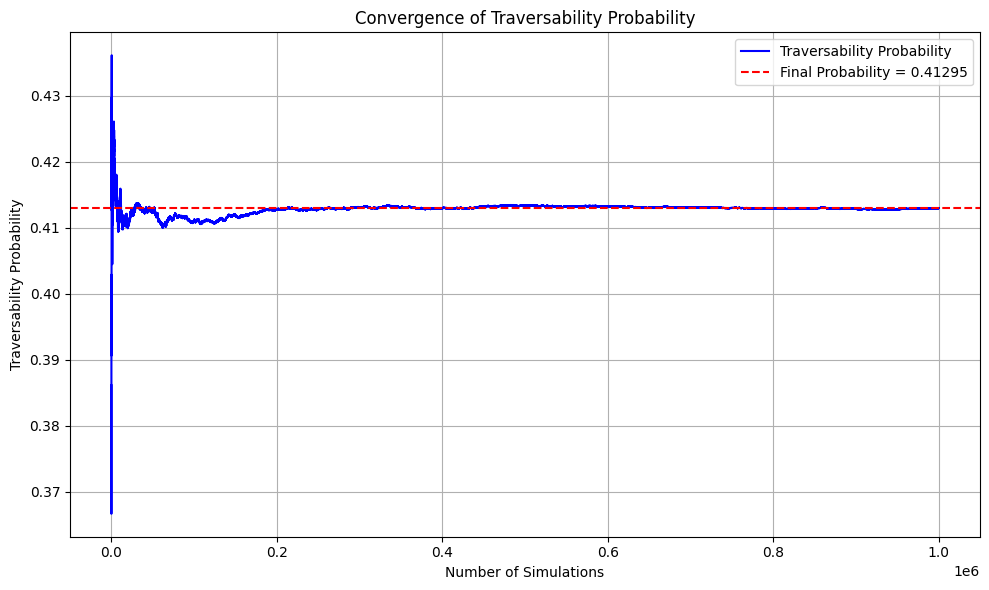

In [14]:
print("Estimated probability of traversability (1,000,000 simulations): {}".format(0.41295))
Image(filename='pure_random_sampling_results_option2.png')